

# Numerical precision of the logistic loss

### Colab to reproduce the experiments in http://fa.bianp.net/drafts/derivatives_logistic.html

**Authors**: [Bart van Merriënboer](https://scholar.google.ca/citations?user=XE9SDzgAAAAJ&hl=en) and [Fabian Pedregosa](http://fa.bianp.net). License: [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0)


We compare the accuracy of different implementations of the logistic loss

In [26]:
# @title Config
# whether to download the generated figures
DOWNLOAD = False #@param {type: "boolean"}

In [27]:
%%capture
import matplotlib as mpl
import matplotlib.font_manager as fm

# !wget https://github.com/openmaptiles/fonts/raw/master/open-sans/OpenSans-Light.ttf
# fm.fontManager.ttflist += fm.createFontList(['OpenSans-Light.ttf'])

In [28]:
import numpy as np
import scipy as sp
from scipy import special

from matplotlib import pyplot as plt
from matplotlib import style
style.use('default')
from matplotlib import rc, rcParams
rcParams['font.size'] = 20
# rc('font', family='sans-serif')
# rcParams['font.family'] = 'Open Sans'
# rcParams['font.weight'] = 'light'
# rcParams['mathtext.fontset'] = 'cm'

import mpmath


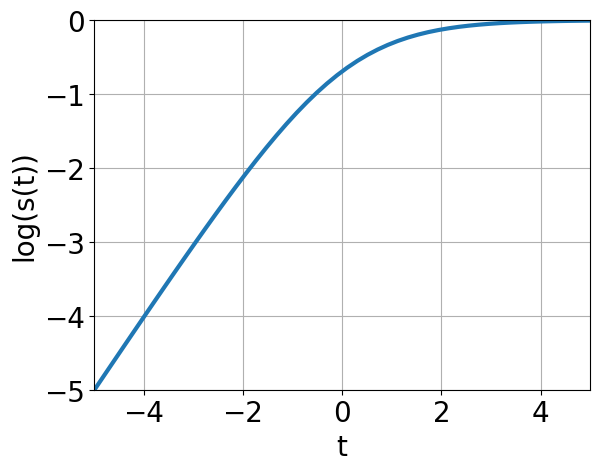

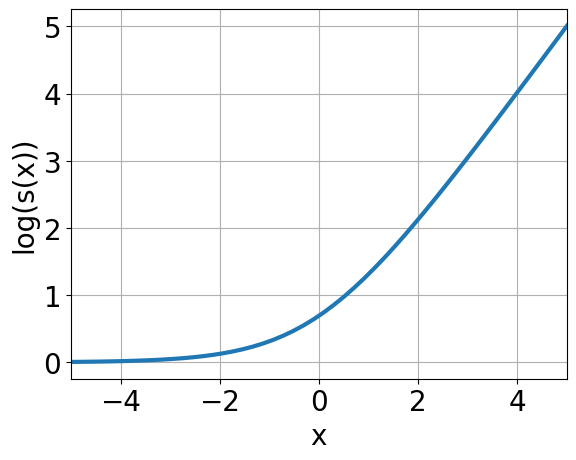

In [29]:
# plot the log-sigmoid function
xx = np.linspace(-5, 5)
yy = -np.log(1 + np.exp(-xx))
plt.plot(xx, yy, lw=3, label='log(s(x))')
plt.xlabel('t')
plt.ylabel('log(s(t))')
plt.grid()
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 0))

if DOWNLOAD:
    f_path = 'log_sigmoid.svg'
    plt.savefig(f_path, transparent=True, dpi=300, bbox_inches='tight')
    # files.download(f_path)

plt.show()

# plot the log-sigmoid function
xx = np.linspace(-5, 5)
yy = np.log(1 + np.exp(xx))
plt.plot(xx, yy, lw=3, label='log(s(x))')
plt.xlabel('x')
plt.ylabel('log(s(x))')
plt.grid()
plt.axis('tight')
plt.xlim((-5, 5))

plt.show()

In [30]:
def logsig_naive(t):
    return np.log(1 / (1 + np.exp(-t)))

def logsig_logsumexp(t):
    return - special.logsumexp([0, -t])

def logsig_log1pexp(t):
    if t < -33.3:
        return t
    elif t <= -18:
        return t - np.exp(t)
    elif t <= 37:
        return -np.log1p(np.exp(-t))
    else:
        return -np.exp(-t)

In [31]:
# Plots with lots of detail around 0, but also high and low numbers
n = 12
nsteps = 100
exps = np.concatenate([np.linspace(n, 0, nsteps), [0], np.linspace(0, n, nsteps)])
xs = 2 ** exps
xs[:nsteps] *= -1
xs[nsteps] = 0

In [32]:
# Control data. Get a ground truth for the logistic loss to compare againsts
# We use as ground truth the naive algorithm computed with mpmath using
# an outrageous amount of significant digits

# Set accuracy of the high-precision calculations
mpmath.mp.dps = 10000

def logsig_mpmath(x):
  if x > 0:
    return mpmath.log(1 / (1 + mpmath.exp(-x)))
  else:
    return x - mpmath.log(mpmath.exp(x) + 1)


ys_baseline = [logsig_mpmath(x) for x in xs]

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_71280/1453250610.py:2: RuntimeWarning: overflow encountered in exp
  return np.log(1 / (1 + np.exp(-t)))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_71280/1453250610.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 + np.exp(-t)))


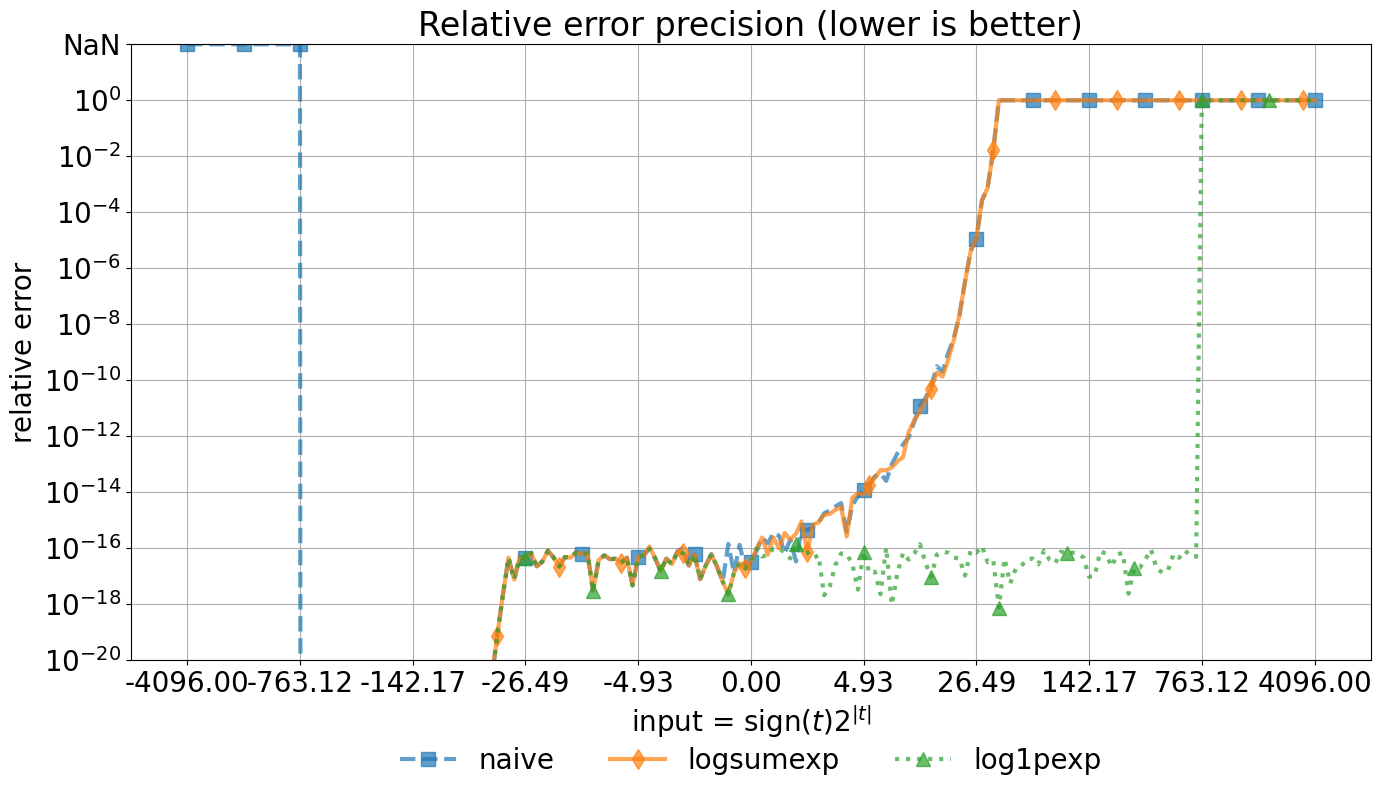

In [ ]:
# Construct a plot with labels
logfuncs = (logsig_naive, logsig_logsumexp, logsig_log1pexp)
logfuncs_names = ("naive", "logsumexp", "log1pexp")


fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Relative error precision (lower is better)")
for i, (method, label, fmt, marker) in enumerate(zip(logfuncs, logfuncs_names, ("--", "-", ":"), ('s', 'd', '^'))):
    ys = [method(x) for x in xs]


    abs_error = [abs(y_approx - y) for y_approx, y in zip(ys, ys_baseline)]
    rel_error = [e / abs(y) for e, y in zip(abs_error, ys_baseline)]

    # those that overflow, assign them relative error = 1.
    for j in range(len(rel_error)):
        if mpmath.isnan(rel_error[j]) or mpmath.isinf(rel_error[j]):
            rel_error[j] = 100.

    ax.plot(rel_error, fmt, marker=marker, markevery=10 + i, markersize=10,  label=label, alpha=0.7, lw=3)
ax.set_xticks(np.arange(len(xs))[::nsteps // 5])
ax.set_xticklabels("{:.2f}".format(x) for x in xs[::nsteps // 5])
ax.set_xlabel("input = sign$(t) 2^{|t|}$")
ax.set_yscale("log")
yticks = np.logspace(2, -20, 12)
ax.set_yticks(yticks)
# set the label for 10 to NaN
# need to draw on canvas to set the ticks
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'NaN'
ax.set_yticklabels(labels)
ax.set_ylim((1e-20, 100))
ax.set_ylabel("relative error")
ax.legend(loc='upper center', frameon=False, bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.grid()

if DOWNLOAD:
  f_path = 'precision_logloss.svg'
  plt.savefig(f_path, transparent=True, dpi=300, bbox_inches='tight')
  # files.download(f_path)

plt.show()

# Numerical precision of the logistic loss derivative

Similar plots as before, this time for the derivative of the logistic loss.

In [ ]:
def expitb_naive(t, b):
    return special.expit(t) - b

def expitb_v2(t, b):
    exp_nt = np.exp(-t)
    return ((1 - b) - b * exp_nt) / (1 + exp_nt)

def expitb_sign(t, b):
    if t < 0:
        exp_t = np.exp(t)
        return ((1 - b) * exp_t - b) / (1 + exp_t)
    else:
        exp_nt = np.exp(-t)
        return ((1 - b) - b * exp_nt) / (1 + exp_nt)

In [ ]:
# Control data. Get a ground truth for the logistic loss to compare againsts
# We use as ground truth the naive algorithm computed with mpmath using
# an outrageous amount of significant digits

# Set accuracy of the high-precision calculations
mpmath.mp.dps = 10000

def expit_mpmath(t, b):
    if t < 0:
      exp_t = mpmath.exp(t)
      return ((1 - b) * exp_t - b) / (1 + exp_t)
    else:
      exp_nt = mpmath.exp(-t)
      return ((1 - b) - b * exp_nt) / (1 + exp_nt)

def naive_mpmath(t,b):
   return 1/(1+mpmath.exp(-t)) - b

# Plots with lots of detail around 0, but also high and low numbers
n = 12
nsteps = 100
exps = np.concatenate([np.linspace(n, 0, nsteps), [0], np.linspace(0, n, nsteps)])
xs = 2 ** exps
xs[:nsteps] *= -1
xs[nsteps] = 0


In [ ]:
bs = np.linspace(0, 1, 32)
grad_ys_baseline = [[expit_mpmath(x, b) for b in bs] for x in xs]

grad_logfuncs = (expitb_naive, expitb_v2, expitb_sign, naive_mpmath)
grad_logfuncs_names = ("naive", "v2", "sign","naive_mpmath")

rel_error = {}
for i, (method, label) in enumerate(zip(grad_logfuncs, grad_logfuncs_names)):
    ys = [[method(x, b) for b in bs] for x in xs]

    def e(y_approx, y):
        return abs(y_approx - y) / abs(y)

    tmp_error = [max(map(e, x, y)) for x, y in zip(ys, grad_ys_baseline)]
    # those that overflow, assign them relative error = 100
    for j in range(len(tmp_error)):
        if mpmath.isnan(tmp_error[j]) or mpmath.isinf(tmp_error[j]):
            tmp_error[j] = 100.
    rel_error[label] = tmp_error


/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_71280/1796265756.py:5: RuntimeWarning: overflow encountered in exp
  exp_nt = np.exp(-t)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_71280/1796265756.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return ((1 - b) - b * exp_nt) / (1 + exp_nt)


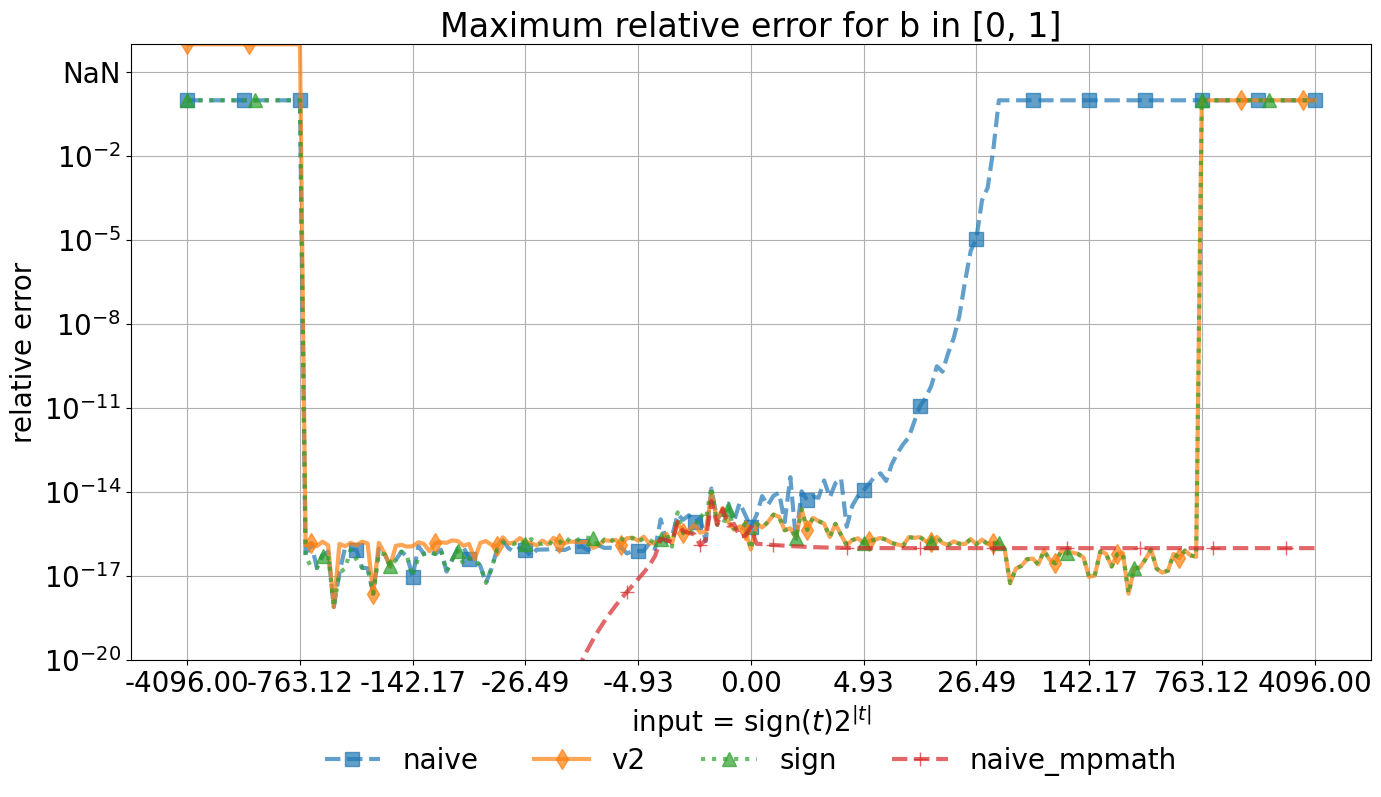

In [ ]:
# Construct a plot with labels
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Maximum relative error for b in [0, 1]")
for i, (label, fmt, marker) in enumerate(zip(grad_logfuncs_names, ("--", "-", ":","--"), ("s", "d", "^","+"))):

    ax.plot(rel_error[label], fmt, marker=marker, markevery=10 + i, markersize=10,  label=label, alpha=0.7, lw=3)
ax.set_xticks(np.arange(len(xs))[::nsteps // 5])
ax.set_xticklabels("{:.2f}".format(x) for x in xs[::nsteps // 5])
ax.set_xlabel("input = sign$(t) 2^{|t|}$")
ax.set_yscale("log")
yticks = np.logspace(1, -20, 8)
ax.set_yticks(yticks)
# set the label for 100 to NaN
# need to draw on canvas to set the ticks
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'NaN'
ax.set_yticklabels(labels)
ax.set_ylim((1e-20, 100))
ax.set_ylabel("relative error")
ax.legend(loc="upper center", frameon=False, bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.grid()

if DOWNLOAD:
    f_path = "precision_grad_logloss.svg"
    plt.savefig(f_path, transparent=True, dpi=300, bbox_inches="tight")

plt.show()